# Movie Genre Prediction

In [1]:
import zipfile
import pandas as pd
import numpy as np
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, multilabel_confusion_matrix
from sklearn.pipeline import Pipeline
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import text_processing as tp

sns.set(style="whitegrid", color_codes=True)

### Purpose of script
This script uses the ["The Movies Dataset"](https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv) 
dataset to train a model that predicts a movie's genre given its title and description. <br>

To retrain the model and reproduce the analysis, follow the link to download zipped folder and save it in the ./data folder.

### Extract data

If you haven't already unzipped the downloaded file run the cell below to unzip.

In [2]:
MOVIE_DATA_DIR = './data/archive.zip'
TARGET_DIR = './data/'

# Check if zip file exists and extract if it does
try:
    with open(MOVIE_DATA_DIR) as f:
        with zipfile.ZipFile(MOVIE_DATA_DIR, 'r') as zip_ref:
            zip_ref.extractall(TARGET_DIR)
except IOError:
    print("File not accessible")

### Load Data

In [3]:
MOVIE_DATA_DIR = './data/movies_metadata.csv'

# Load the data into a DataFrame
raw_data = pd.read_csv(MOVIE_DATA_DIR, sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

We will only keep the *Genre*, *Title* and *Plot* for each film:

In [4]:
column_names = {'original_title': 'title',
                'overview': 'description',
                'genres': 'genres'}
movie_data = raw_data[column_names.keys()].copy()
# Rename columns
movie_data.rename(columns=column_names, inplace=True)
raw_records = len(movie_data)
print("There are {} records in the dataset.".format(raw_records))
# Display first 5 rows of dataset
movie_data.head()

There are 45466 records in the dataset.


,title,description,genres
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


### Summarise dataset information

In [5]:
unique_movies = len(movie_data['title'].unique())
print("There are {} unique movies in the dataset.".format(unique_movies))

There are 43373 unique movies in the dataset.


There are titles that contain non-english characters that need to be removed:

In [6]:
movie_data = movie_data[movie_data['title'].map(lambda x: x.isascii())].reset_index(drop=True)
english_title_movies = len(movie_data)
print("{} movies were removed from the dataset.".format(raw_records-english_title_movies))

6177 movies were removed from the dataset.


We will also remove any movies without a description or title:

In [7]:
# Exclude any movies without title or description
movie_data = movie_data.loc[~movie_data['title'].isin([''])]
movie_data = movie_data.loc[~movie_data['title'].isin([''])]
complete_movies = len(movie_data)
print("{} movies were removed from the dataset.".format(english_title_movies-complete_movies))

0 movies were removed from the dataset.


### Data pre-processing

Make sure that all datatypes are consistent:

In [8]:
# Change Title and Description types to strings
movie_data['title'] = movie_data['title'].astype(str)
movie_data['description'] = movie_data['description'].astype(str)

We now need to convert the genres column to a list of genres

In [9]:
def extract_genres(row):
    genres_list = row.replace("'", '"')  # Replace single quotes to convert to json
    genres_json = json.loads(genres_list)  # Convert string to json
    genres = [gen_dict['name'] for gen_dict in genres_json]  # Extract all genres in dict
    return genres

# Reassign the genres column to a list of the movie genres
movie_data['genres'] = movie_data['genres'].apply(lambda x: extract_genres(x))

Let's exclude any movies that do not have any genres assigned to them.

In [10]:
movie_data = movie_data[movie_data['genres'].map(lambda x: len(x)) > 0]
records_with_genres = len(movie_data)
print("{} movies were removed from the dataset.".format(complete_movies-records_with_genres))

2062 movies were removed from the dataset.


There are movies with multiple same genres that need to be removed:

In [11]:
# Get a unique list of genres for each movie
movie_data['genres'] = movie_data['genres'].apply(lambda x: list(set(x)))

Now that we have the complete dataset let's explore how many genres are available. We will use NLTK which is a natural language processing tool to get the word frequencies:

In [12]:
# Create a list of all the available genres
all_genres = [item for sublist in movie_data['genres'].values for item in sublist]
unique_genres = len(set(all_genres))
print("There are {} unique genres in the dataset.".format(unique_genres))

# Get the term frequencies
all_genres = nltk.FreqDist(all_genres)
# Create a DataFrame for plotting
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
# Before we plot let's normalise the results by the total number of movies
all_genres_df['Normalised Count'] = all_genres_df['Count'] / all_genres_df['Count'].sum()

There are 27 unique genres in the dataset.


Let's visualise the results:

In [13]:
def plot_barplot(data):
    '''
    Takes in a dataframe with Genres and Counts 
    and plots a barplot of the data.
    '''
    pal = sns.color_palette("Reds_d", len(data))
    rank = data['Normalised Count'].argsort().argsort()
    g = data.nlargest(columns="Count", n=50) 
    plt.figure(figsize=(8, 7)) 
    ax = sns.barplot(data=g, x= "Normalised Count", y = "Genre", palette=np.array(pal[::-1])) 
    ax.set(ylabel = 'Normalised Count') 
    plt.show()

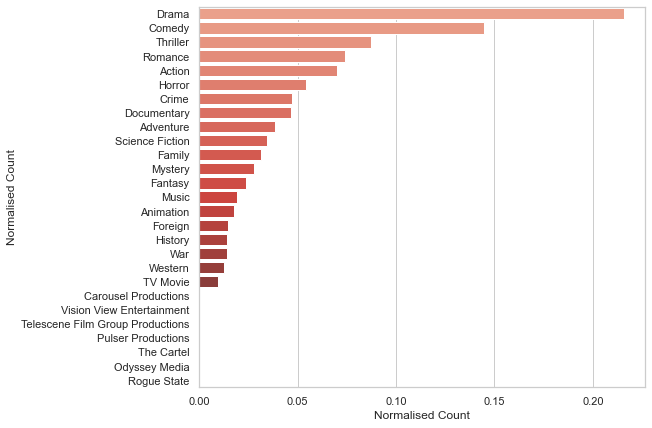

In [14]:
plot_barplot(all_genres_df)

We see that the last 7 genres do not fall under any specific category so we remove them.

In [15]:
unknown_genres = ['Carousel Productions',
                  'Vision View Entertainment',
                  'Telescene Film Group Productions',
                  'Odyssey Media',
                  'Pulser Productions',
                  'Rogue State',
                  'The Cartel']

Let's loop though all our entries and remove these genres since their count is too small.

In [16]:
def remove_genres(row):
    '''
    Loops through all genres for each film and replaces with "Other"
    if genre is in the unknown_genres list.
    '''
    new_items = [x for x in row if x not in unknown_genres]
    
    return new_items

# Remove unknown genres from dataset
movie_data['genres'] = movie_data['genres'].apply(lambda x: remove_genres(x))  
# Reset df index
movie_data.reset_index(drop=True, inplace=True)

In [17]:
# Create a list of all the available genres
all_genres = [item for sublist in movie_data['genres'].values for item in sublist]
unique_genres = len(set(all_genres))
print("There are {} unique genres in the dataset.".format(unique_genres))

# Get the term frequencies
all_genres = nltk.FreqDist(all_genres)
# Create a DataFrame for plotting
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
# Before we plot let's normalise the results by the total number of movies
all_genres_df['Normalised Count'] = all_genres_df['Count'] / all_genres_df['Count'].sum()

There are 20 unique genres in the dataset.


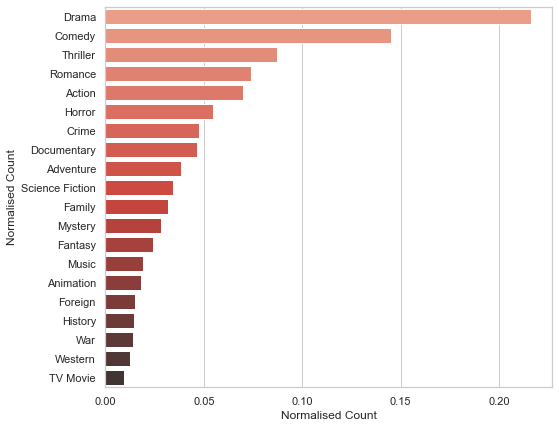

In [18]:
plot_barplot(all_genres_df)

The distribution of genres is skewed so when splitting the data for training we will try to stratify the dataset and potentially oversample the minority classes.

#### Text pre-processing

Before we train any models we will need to pre-process our text. <br>
We will follow these steps:
- Join the movie title to the movie description
- Remove whitespace, slashes, non-alphabetic charactes and convert text to lowecase
- Lemmatise the words
- Remove any stopwords
- Join the title and description tokens back into one sentence

The above functions are implemented in the "text_processing.py" module.

In [19]:
movie_data['text'] = \
    movie_data[['title', 'description']].apply(
        lambda row: tp.transform_text(row['title'], row['description']), axis=1)    

# Model training

### 1. Problem statement

This is a multi-label classification problem as a movie can belong to more than one categories. 
We are only looking to return the most likely genre to the user. <br>
There are many algorithms that are inherently multilabel () and others that can be used with a One-Vs-The-Rest wrapper.

### 2. Features & Labels

First we need to one-hot encode our labels.

In [20]:
# Labels
multilabel_binarizer = MultiLabelBinarizer()  # Create a multi-class binariser
y = multilabel_binarizer.fit_transform(movie_data['genres'])  # Fit the binariser to the data and transform

# Features
X = movie_data['text']

# Split data to train and test set
X_train, X_test, y_train, y_test = \
    train_test_split(X.values, y, test_size=0.20, random_state=42)

### 3. Train Model

**Pipeline** <br>
We will use the pipeline utility from scikit learn to then be able to apply the same vectoriser to the new data. <br>
**Vectorizer** <br>
We will use a TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features. <br>
**OneVsRest multi-label strategy** <br>
The Multi-label algorithm accepts a binary mask over multiple labels.  <br>
The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample. <br>
**Estimator** <br>
There are multiple different estimators that we can use including, Logistic Regression, Naive Bayes, LinearSVC. <br>
**Optimisation Metric** <br>
We will optimise the models for f1-score since we seek a balance between Precision and Recall *and* there is an uneven class distribution.

In [37]:
# Instantiate a TF-IDF vecrtorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=10000)

# Estimators to experiment
lr = LogisticRegression(solver='saga')
rf = RandomForestClassifier()  # max_depth=100
gb = GradientBoostingClassifier(random_state=0, learning_rate=1.0)  # n_estimators=100, max_depth=1, 

# List of estimators to try
estimators = [lr, rf, gb]

# Create a list of pipelines to train
pipelines = [Pipeline([('Vectorizer', tfidf_vectorizer),
                       ('Classifier', OneVsRestClassifier(estimator))]) for estimator in estimators]

# Set of parameters to optimise for
parameters_lr = {}
parameters_rf = {'Classifier__estimator__n_estimators': [1, 10],
                 'Classifier__estimator__max_depth': [10, 20]}
parameters_gb = {'Classifier__estimator__n_estimators': [10, 15],
                 'Classifier__estimator__max_depth': [1, 3]}

# Create a list of parameters to optimise for each estimator
parameters_list=[parameters_lr, parameters_rf, parameters_gb]

Train classifiers and get the best model:

In [ ]:
best_pipelines = []
# Loop through all the pipelines and train
for i in range(len(pipelines)):
    # We will use 3-fold cross-validation
    Grid = GridSearchCV(estimator=pipelines[i], param_grid=parameters_list[i], 
                        n_jobs=-1, cv=2, verbose=0, scoring='f1_micro').fit(X_train, y_train)
    best_pipelines.append(Grid.best_estimator_)

We will now train all the estimators with the best parameters and get the one with the best F1-score:

In [ ]:
best_pipeline = None
f1 = 0
for pipe in best_pipelines:
    # Train model
    pipe.fit(X_train, y_train)
    # Make predictions for validation set
    y_pred_test = pipe.predict(X_test)
    # If the current model has a better f1 score than the ones so far
    if f1_score(y_test, y_pred_test, average="micro") > f1:
        best_pipeline = pipe
        f1 = f1_score(y_test, y_pred_test, average="micro")
    # Evaluate model performance on the test set
    print("The F1-score for {} is {:.2f}".format(pipe['Classifier'].estimator,
                                                 f1_score(y_test, y_pred_test, average="micro")))

The best model is the **One vs Rest with Logistic Regression classifier.**

If we wanted to predict as many genres for the movie as accurately as possible, we could optimise the cut-off threshold <br>
above which probabilities will be considered:

In [ ]:
# Get the probabilities for each label 
probabilities = best_pipeline.predict_proba(X_test)

# Calculate the metrics for different probability thresholds
scores, accuracy = {}, {}
for threshold in np.arange(0.0, 1.1, 0.1):
    # make predictions for validation set
    top_genres = np.where(probabilities > threshold, 1, 0)
    # evaluate performance
    accuracy[threshold] = accuracy_score(y_test, top_genres)
    scores[threshold] = f1_score(y_test, top_genres, average="micro")

model_accuracy = pd.DataFrame(data=accuracy.items(), index= accuracy.keys(), columns=['Threshold', 'Accuracy'])
model_f1_score = pd.DataFrame(data=scores.items(), index= scores.keys(), columns=['Threshold', 'F1-Score'])
pd.merge(model_accuracy, model_f1_score, on='Threshold').set_index('Threshold').plot()

### Test model with unseen examples:

In [ ]:
with open("examples.json", "r") as read_file:
    example_movies = json.load(read_file)

In [ ]:
for title, description in example_movies.items():

    processed_data = tp.transform_text(title, description)
    probabilities = best_pipeline.predict_proba([processed_data])
    probabilities_df = pd.DataFrame(probabilities, index=['Probabilities'], columns=multilabel_binarizer.classes_).T
    probabilities_df.sort_values(by='Probabilities', ascending=True)[-4:-1].plot.barh()
    plt.title(title)

Export model to pickle

In [ ]:
model_filename = "./movie_classifier_trained_model.pkl"  

with open(model_filename, 'wb') as filename:  
    joblib.dump({'pipeline': best_pipeline, 'genres': multilabel_binarizer.classes_}, model_filename)

### 4. Train a simple NN as well.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
# Labels
multilabel_binarizer = MultiLabelBinarizer()  # Create a multi-class binariser
y = multilabel_binarizer.fit_transform(movie_data['genres'])  # Fit the binariser to the data and transform

# Features
X = movie_data['text']

# Split data to train and test set
X_train, X_test, y_train, y_test = \
    train_test_split(X.values, y, test_size=0.20, random_state=42)

# Split data to train and validation set
X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [23]:
training_sentences = X_train
validation_sentences = X_val

In [25]:
# Specify hyper-parameters
vocab_size = 10000
embedding_size = 16
max_length = 120
trunc_type = "post"
oov_tok = "<OOV>"

# Create a Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Create a word index
word_index = tokenizer.word_index

# Convert sentences to sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

# Use same tokenizer in test data - a lot more OOVs might be created
validation_sentences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sentences, maxlen=max_length, truncating=trunc_type)

In [26]:
# Reverse word index
reverse_word_index = dict([(value, key) for key, value in word_index.items()])


def decode_review(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])


# Examine an example
print(decode_review(training_padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? time minor every year june nearly athlete high school college chosen amateur baseball draft play minor league inspiring documentary follows life two young player arduous journey launch major league baseball career one face final year <OOV> another player wrestle pressure keeping million dollar first round draft contract intact thrilling emotional journey illuminates power determination whether dream achieved lost
time minor every year june nearly athlete high school college chosen amateur baseball draft play minor league inspiring documentary follows life two young player arduous journey launch major league baseball career one face final year tryout another player wrestle pressure keeping million dollar first round draft contract intact thrilling emotional journey illuminates power determination whether dream achieved lost


In [27]:
# Define a Sequential Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  # Averages across the vector to flatten it out
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='sigmoid')])

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               4352      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1

In [29]:
training_padded.shape

(26802, 120)

In [31]:
# Fit model
num_epochs = 20
history = model.fit(training_padded, y_train, epochs=num_epochs,
          validation_data=(validation_padded, y_val))

Epoch 1/50
838/838 [==============================] - 2s 3ms/step - loss: 5.5847 - accuracy: 0.2574 - val_loss: 5.3891 - val_accuracy: 0.2726
Epoch 2/50
838/838 [==============================] - 2s 2ms/step - loss: 5.2752 - accuracy: 0.2737 - val_loss: 5.2417 - val_accuracy: 0.2991
Epoch 3/50
838/838 [==============================] - 2s 2ms/step - loss: 5.1599 - accuracy: 0.2902 - val_loss: 5.1904 - val_accuracy: 0.3068
Epoch 4/50
838/838 [==============================] - 2s 2ms/step - loss: 4.9287 - accuracy: 0.3061 - val_loss: 4.9279 - val_accuracy: 0.3229
Epoch 5/50
838/838 [==============================] - 2s 3ms/step - loss: 4.7250 - accuracy: 0.3069 - val_loss: 4.8685 - val_accuracy: 0.3253
Epoch 6/50
838/838 [==============================] - 2s 2ms/step - loss: 4.6238 - accuracy: 0.3076 - val_loss: 4.8870 - val_accuracy: 0.3186
Epoch 7/50
838/838 [==============================] - 2s 2ms/step - loss: 4.5483 - accuracy: 0.3102 - val_loss: 4.8837 - val_accuracy: 0.3209
Epoch 

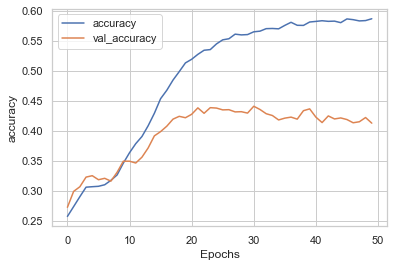

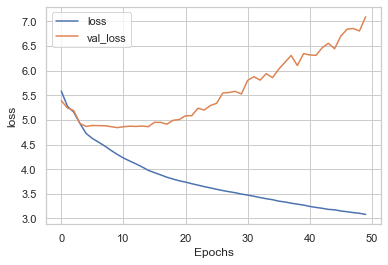

In [36]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [33]:
new_sentence = ["A dynamic young entrepreneur finds herself locked in a hotel room with the corpse of her dead lover. She hires a prestigious lawyer to defend her and they work together to figure out what actually happened."]

test_sentence = tokenizer.texts_to_sequences(new_sentence)
padded_sentence = pad_sequences(test_sentence, maxlen=max_length, truncating=trunc_type)
probabilities = model.predict(padded_sentence)
probabilities
top_genres = np.where(probabilities > 0.1, 1, 0)
top_genres

array([[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [34]:
test_sentence = tokenizer.texts_to_sequences(X_test)
padded_sentence = pad_sequences(test_sentence, maxlen=max_length, truncating=trunc_type)
probabilities = model.predict(padded_sentence)
probabilities

# make predictions for validation set
top_genres = np.where(probabilities > 0.1, 1, 0)
# evaluate performance
accuracy = accuracy_score(y_test, top_genres)
scores = f1_score(y_test, top_genres, average="micro")

In [35]:
for title, description in example_movies.items():

    processed_data = tp.transform_text(title, description)
    test_sentence = tokenizer.texts_to_sequences([processed_data])
    padded_sentence = pad_sequences(test_sentence, maxlen=max_length, truncating=trunc_type)

    probabilities = model.predict(padded_sentence)
    probabilities_df = pd.DataFrame(probabilities, index=['Probabilities'], columns=multilabel_binarizer.classes_).T
    probabilities_df.sort_values(by='Probabilities', ascending=True)[-4:-1].plot.barh()
    plt.title(title)

NameError: name 'example_movies' is not defined